# Analyzing New York City employees' payroll database 

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

/opt/homebrew/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version. The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/opt/homebrew/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


## Data Source: [NYC open data](https://data.cityofnewyork.us/City-Government/Citywide-Payroll-Data-Fiscal-Year-/k397-673e/data)

In [2]:
import pandas as pd
df = pd.read_csv('Citywide_Payroll_Data__Fiscal_Year_.csv')
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("-", "_")
df.columns = df.columns.str.lower()
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
df.shape

(2864545, 17)

Previous versions of the dataset didn't import all the years correctly, so I'll do these sanity checks a couple of times

In [4]:
df.fiscal_year.value_counts()

2019    592431
2020    590210
2021    573477
2017    562266
2018    546161
Name: fiscal_year, dtype: int64

#### Cleaning the data

The database includes people whose work locations are outside of NYC. For this analyses, I'm only including employees with work locations in NYC boroughs. Since Staten Island wasn't listed (unless included in the "other" location, this is filtered down to Queens, Manhattan, Bronx and Brooklyn.

In [5]:
boroughs = ['QUEENS', 'MANHATTAN', 'BROOKLYN', 'BRONX']

In [6]:
df = df[df.work_location_borough.isin(boroughs)]

In [7]:
df.shape

(2760682, 17)

Note: This reduced the dataset by 103,863 rows.

In [8]:
df['total_pay'] = df.regular_gross_paid + df.total_ot_paid + df.total_other_pay

In [9]:
df.sort_values(by='total_pay', ascending = False).head(10)

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,total_pay
1705625,2020,56.00,POLICE DEPARTMENT,MORALES,JOSE,NaN,12/20/1998,MANHATTAN,SUPERVISOR OF SCHOOL SECURITY,CEASED,"57,813.00",per Annum,0.00,0.00,0.00,0.00,"650,000.00","650,000.00"
979064,2018,826.00,DEPT OF ENVIRONMENT PROTECTION,LAUDANDO,CHRISTOPHER,NaN,04/26/1993,BROOKLYN,SENIOR STATIONARY ENGINEER,ACTIVE,575.52,per Day,"2,045.72","362,522.47",767.50,"153,226.04",563.00,"516,311.51"
2291068,2021,996.00,NYC HOUSING AUTHORITY,MUSTACIUOLO,VITO,J,02/26/2018,MANHATTAN,EXECUTIVE DIRECTOR,ACTIVE,"258,000.00",per Annum,"1,820.00","257,260.30",0.00,0.00,"258,000.00","515,260.30"
979061,2018,826.00,DEPT OF ENVIRONMENT PROTECTION,BUI,HUU,NaN,04/26/1993,BRONX,STATIONARY ENGINEER,ACTIVE,467.20,per Day,"2,085.72","265,284.18","1,380.00","182,178.73","60,347.27","507,810.18"
1117631,2019,57.00,FIRE DEPARTMENT,PHILLIPS,LYNDELLE,T,06/05/2006,BROOKLYN,ADMINISTRATIVE STAFF ANALYST,CEASED,"129,611.00",per Annum,140.00,"500,000.00",0.00,0.00,0.00,"500,000.00"
979062,2018,826.00,DEPT OF ENVIRONMENT PROTECTION,GIOVANNIELLO,FRANK,J,06/06/1994,QUEENS,STATIONARY ENGINEER,ACTIVE,467.20,per Day,"2,085.72","264,925.47","1,016.50","178,476.58","50,899.01","494,301.06"
979073,2018,826.00,DEPT OF ENVIRONMENT PROTECTION,ANDERSON,COURTNAY,D,02/24/1986,QUEENS,SENIOR STATIONARY ENGINEER,ACTIVE,575.52,per Day,"2,045.72","357,426.59",546.50,"134,050.29",563.00,"492,039.88"
979077,2018,826.00,DEPT OF ENVIRONMENT PROTECTION,ALI,ZAINOOL,NaN,12/02/1996,BROOKLYN,SENIOR STATIONARY ENGINEER,ACTIVE,575.52,per Day,"2,045.72","348,668.06",536.75,"129,141.26",563.00,"478,372.32"
979079,2018,826.00,DEPT OF ENVIRONMENT PROTECTION,KITTEL,ANDREW,M,03/05/1990,BROOKLYN,SENIOR STATIONARY ENGINEER,ACTIVE,575.52,per Day,"2,007.72","352,014.45",529.25,"123,602.33",563.00,"476,179.78"
979065,2018,826.00,DEPT OF ENVIRONMENT PROTECTION,PASTORE,DANIEL,NaN,03/21/1988,MANHATTAN,STATIONARY ENGINEER,ACTIVE,467.20,per Day,"2,085.72","263,164.37",849.75,"148,809.87","53,345.91","465,320.15"


In [10]:
df.total_pay.max()

650000.0

In [11]:
df.total_pay.min()

-137960.51

### Ignoring the negatives. Assuming this is people who owe money to the city. The dataset alone cannot answer this so leaving this to reporting

### Interesting to see Jose Morales made $650K in 2020 and is no longer on city payroll

In [12]:
df.query('last_name == "MORALES"').query('first_name == "JOSE"').query('agency_name == "POLICE DEPARTMENT"').query('agency_start_date == "12/20/1998"')

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,total_pay
1705625,2020,56.00,POLICE DEPARTMENT,MORALES,JOSE,NaN,12/20/1998,MANHATTAN,SUPERVISOR OF SCHOOL SECURITY,CEASED,"57,813.00",per Annum,0.00,0.00,0.00,0.00,"650,000.00","650,000.00"


### Let's dive into overtime now :') !

In [13]:
df.sort_values(by='total_ot_paid', ascending = False).head(10)

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,total_pay
2291076,2021,996.00,NYC HOUSING AUTHORITY,PROCIDA,ROBERT,NaN,04/13/1987,BRONX,SUPERVISOR PLUMBER,ACTIVE,387.03,per Day,"1,820.00","100,627.80","2,249.50","248,749.72","7,215.34","356,592.86"
2291070,2021,816.00,DEPT OF HEALTH/MENTAL HYGIENE,MCGROARTY,MICHAEL,NaN,10/06/2014,QUEENS,STATIONARY ENGINEER,ACTIVE,508.80,per Day,"2,080.00","132,288.00","2,374.75","238,829.13","40,105.00","411,222.13"
2291085,2021,996.00,NYC HOUSING AUTHORITY,MARKOWSKI,JAKUB,NaN,05/31/2016,BRONX,PLUMBER,ACTIVE,369.53,per Day,"1,820.00","96,077.80","2,119.50","223,776.86","5,899.29","325,753.95"
2291072,2021,816.00,DEPT OF HEALTH/MENTAL HYGIENE,PETTIT,PATRICK,J,08/02/2010,MANHATTAN,STATIONARY ENGINEER,ACTIVE,508.80,per Day,"2,080.00","132,288.00","2,152.75","218,694.96","38,611.82","389,594.78"
2291071,2021,816.00,DEPT OF HEALTH/MENTAL HYGIENE,HALLAHAN,PATRICK,M,02/26/2018,BROOKLYN,STATIONARY ENGINEER,ACTIVE,508.80,per Day,"2,080.00","132,288.00","2,115.25","218,628.18","56,616.07","407,532.25"
2291081,2021,3.00,BOARD OF ELECTION,"ORTIZ, JR",ANTONIO,NaN,08/27/1995,MANHATTAN,SENIOR SYSTEMS ANALYSTS,ACTIVE,"117,003.00",per Annum,"1,820.00","116,673.77","2,461.25","217,915.94","2,974.95","337,564.66"
2234227,2020,996.00,NYC HOUSING AUTHORITY,PROCIDA,ROBERT,NaN,04/13/1987,BRONX,SUPERVISOR PLUMBER,ACTIVE,387.03,per Day,"1,820.00","100,627.80","1,944.50","215,022.81","6,468.93","322,119.54"
2234228,2020,996.00,NYC HOUSING AUTHORITY,ORTIZ,JOSE,NaN,11/27/1989,QUEENS,SUPERVISOR PLUMBER,ACTIVE,387.03,per Day,"1,820.00","100,627.80","1,937.50","214,248.85","5,860.74","320,737.39"
1069369,2018,996.00,NYC HOUSING AUTHORITY,GIURBINO,VINCENZO,NaN,04/28/2003,BROOKLYN,PLUMBER,ACTIVE,361.48,per Day,"1,825.00","93,984.80","2,043.00","213,634.68","7,539.44","315,158.92"
2291078,2021,996.00,NYC HOUSING AUTHORITY,DALEY,GARFIELD,D,05/24/1994,BRONX,SUPERVISOR ELECTRICIAN,ACTIVE,460.25,per Day,"1,820.00","119,469.25","2,032.50","200,038.56","28,316.97","347,824.78"


#### Five of these ten have the word 'plumber' in their title. Let's inspect further

In [14]:
import re
df[df['title_description'].str.contains('.PLUMBER')== True].agency_name.value_counts()

NYC HOUSING AUTHORITY             83
DEPARTMENT OF EDUCATION ADMIN     34
DEPT OF ENVIRONMENT PROTECTION    27
DEPT OF PARKS & RECREATION        23
FIRE DEPARTMENT                   22
DEPT. OF HOMELESS SERVICES        14
DEPARTMENT OF SANITATION          12
POLICE DEPARTMENT                 12
HRA/DEPT OF SOCIAL SERVICES       10
DEPARTMENT OF CORRECTION           5
DEPARTMENT OF TRANSPORTATION       5
DEPT OF CITYWIDE ADMIN SVCS        5
COMMUNITY COLLEGE (HOSTOS)         1
Name: agency_name, dtype: int64

In [15]:
df[df['title_description'].str.contains('.PLUMBER')== True].fiscal_year.value_counts()

2019    54
2021    52
2018    51
2020    50
2017    46
Name: fiscal_year, dtype: int64

In [16]:
df[df['title_description'].str.contains('.PLUMBER')== True].groupby(by='fiscal_year').total_ot_paid.mean()

fiscal_year
2017   56,514.89
2018   49,544.42
2019   55,636.56
2020   63,193.66
2021   69,361.16
Name: total_ot_paid, dtype: float64

In [17]:
df[df['title_description'].str.contains('.PLUMBER')== True].groupby(['fiscal_year', 'agency_name']).total_ot_paid.sum()

fiscal_year  agency_name                  
2017         DEPARTMENT OF CORRECTION           64,794.76
             DEPARTMENT OF EDUCATION ADMIN     205,382.19
             DEPARTMENT OF SANITATION           65,996.66
             DEPARTMENT OF TRANSPORTATION       34,121.74
             DEPT OF CITYWIDE ADMIN SVCS       153,541.04
                                                 ...     
2021         DEPT. OF HOMELESS SERVICES         60,100.23
             FIRE DEPARTMENT                   313,467.52
             HRA/DEPT OF SOCIAL SERVICES        35,275.05
             NYC HOUSING AUTHORITY           2,161,223.63
             POLICE DEPARTMENT                 112,736.36
Name: total_ot_paid, Length: 61, dtype: float64

In [18]:
df[df['title_description'].str.contains('.PLUMBER')== True].groupby(['fiscal_year', 'agency_name']).total_pay.sum()

fiscal_year  agency_name                  
2017         DEPARTMENT OF CORRECTION          167,119.36
             DEPARTMENT OF EDUCATION ADMIN     917,629.39
             DEPARTMENT OF SANITATION          268,805.10
             DEPARTMENT OF TRANSPORTATION      137,204.30
             DEPT OF CITYWIDE ADMIN SVCS       258,680.92
                                                 ...     
2021         DEPT. OF HOMELESS SERVICES        363,642.33
             FIRE DEPARTMENT                   728,087.23
             HRA/DEPT OF SOCIAL SERVICES       237,415.29
             NYC HOUSING AUTHORITY           4,044,701.87
             POLICE DEPARTMENT                 415,946.72
Name: total_pay, Length: 61, dtype: float64

In [19]:
df[df['title_description'].str.contains('.PLUMBER')== True].total_ot_paid.mean()

58882.56102766799

In [20]:
df[df['title_description'].str.contains('.PLUMBER')== True].groupby(by='agency_name').total_ot_paid.sum()

agency_name
COMMUNITY COLLEGE (HOSTOS)           5,569.37
DEPARTMENT OF CORRECTION           457,030.12
DEPARTMENT OF EDUCATION ADMIN      756,051.84
DEPARTMENT OF SANITATION           220,854.98
DEPARTMENT OF TRANSPORTATION       176,641.66
DEPT OF CITYWIDE ADMIN SVCS        679,538.41
DEPT OF ENVIRONMENT PROTECTION     619,263.96
DEPT OF PARKS & RECREATION       1,563,329.13
DEPT. OF HOMELESS SERVICES         556,608.68
FIRE DEPARTMENT                  1,200,328.52
HRA/DEPT OF SOCIAL SERVICES        381,300.86
NYC HOUSING AUTHORITY            7,684,816.42
POLICE DEPARTMENT                  595,953.99
Name: total_ot_paid, dtype: float64

In [21]:
df[df['title_description'].str.contains('.PLUMBER')== True].groupby(by='agency_name').regular_gross_paid.sum()

agency_name
COMMUNITY COLLEGE (HOSTOS)          97,302.80
DEPARTMENT OF CORRECTION           500,107.30
DEPARTMENT OF EDUCATION ADMIN    3,379,790.62
DEPARTMENT OF SANITATION         1,067,285.12
DEPARTMENT OF TRANSPORTATION       503,385.05
DEPT OF CITYWIDE ADMIN SVCS        503,385.05
DEPT OF ENVIRONMENT PROTECTION   2,521,535.93
DEPT OF PARKS & RECREATION       2,261,931.33
DEPT. OF HOMELESS SERVICES       1,407,857.85
FIRE DEPARTMENT                  2,045,864.15
HRA/DEPT OF SOCIAL SERVICES      1,006,383.07
NYC HOUSING AUTHORITY            7,966,780.11
POLICE DEPARTMENT                1,191,483.99
Name: regular_gross_paid, dtype: float64

## 📝 There were 52 plumbers on city payroll in 2021 and they made about \\$69,000 on average in overtime. Overall, the agency shelled out over $2 million in overtime just to its plumbers in 2021.

### NYCHA plumbers made \\$31,865 in base salary in total over five years. In overtime they made over $7.6 million

### Which agencies paid the most overtime and in which year?

In [22]:
# pd.set_option('display.max_rows', None)
df.groupby(['agency_name', 'fiscal_year']).total_ot_paid.sum().reset_index().sort_values(by='total_ot_paid', ascending = False).head(10)

,agency_name,fiscal_year,total_ot_paid
624,POLICE DEPARTMENT,2020,"789,030,906.10"
621,POLICE DEPARTMENT,2017,"743,243,130.21"
623,POLICE DEPARTMENT,2019,"705,970,021.11"
622,POLICE DEPARTMENT,2018,"690,899,013.79"
625,POLICE DEPARTMENT,2021,"481,517,169.18"
441,FIRE DEPARTMENT,2021,"330,179,136.67"
437,FIRE DEPARTMENT,2017,"321,097,174.36"
439,FIRE DEPARTMENT,2019,"319,265,956.70"
438,FIRE DEPARTMENT,2018,"313,309,302.92"
440,FIRE DEPARTMENT,2020,"312,990,484.38"


In [23]:
df.groupby(by='agency_name').total_ot_paid.sum().reset_index().sort_values(by='total_ot_paid', ascending = False).head(5)

,agency_name,total_ot_paid
125,POLICE DEPARTMENT,"3,410,660,240.39"
88,FIRE DEPARTMENT,"1,596,842,055.03"
59,DEPARTMENT OF CORRECTION,"981,672,183.09"
65,DEPARTMENT OF SANITATION,"790,873,824.62"
114,NYC HOUSING AUTHORITY,"553,297,085.88"


In [24]:
df.query('agency_name == "NYC HOUSING AUTHORITY"').groupby(by='fiscal_year').total_ot_paid.sum()

fiscal_year
2017    86,906,355.13
2018    93,188,194.70
2019    94,279,021.87
2020   136,858,912.87
2021   142,064,601.31
Name: total_ot_paid, dtype: float64

In [25]:
from plotnine import *

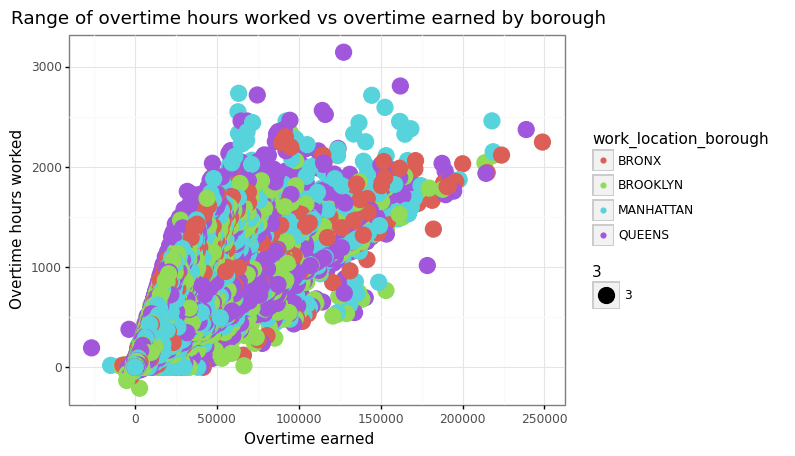

<ggplot: (684930045)>

In [26]:
(
    ggplot(df,
        aes('total_ot_paid', 'ot_hours'))
        + geom_point(aes(color='work_location_borough', size=3))
        + theme(figure_size=(12, 6))
        + theme_bw()
        + labs(
            title = "Range of overtime hours worked vs overtime earned by borough",
            y = "Overtime hours worked",
            x = "Overtime earned"
        )
)

# Let's zoom into those who made over $200K in overtime

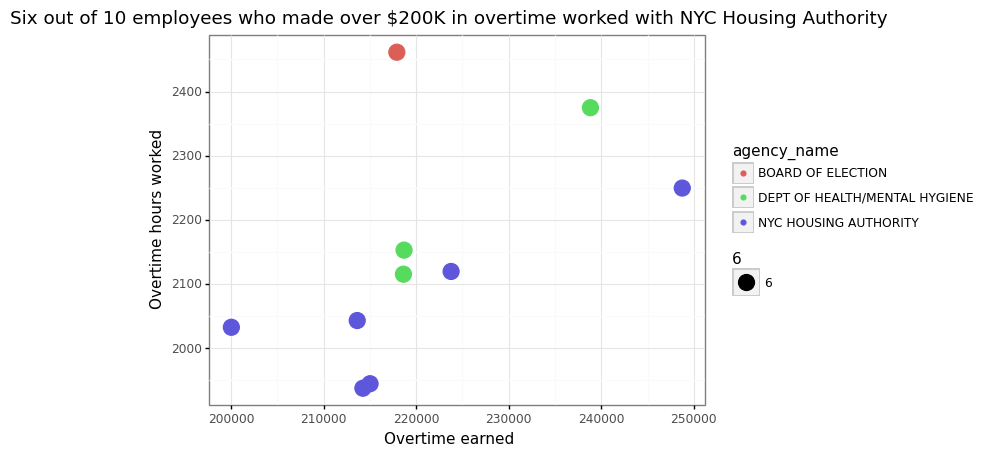

<ggplot: (357759729)>

In [27]:
(
    ggplot(df.sort_values(by='total_ot_paid', ascending = False).head(10),
        aes('total_ot_paid', 'ot_hours'))
        + geom_point(aes(color='agency_name', size=6))
        + theme(figure_size=(8, 5))
        + theme_bw()
        + labs(
            title = "Six out of 10 employees who made over $200K in overtime worked with NYC Housing Authority",
            y = "Overtime hours worked",
            x = "Overtime earned"
        )
)

### I'm also interested in seeing how people's regular hours compare with their overtime hours.

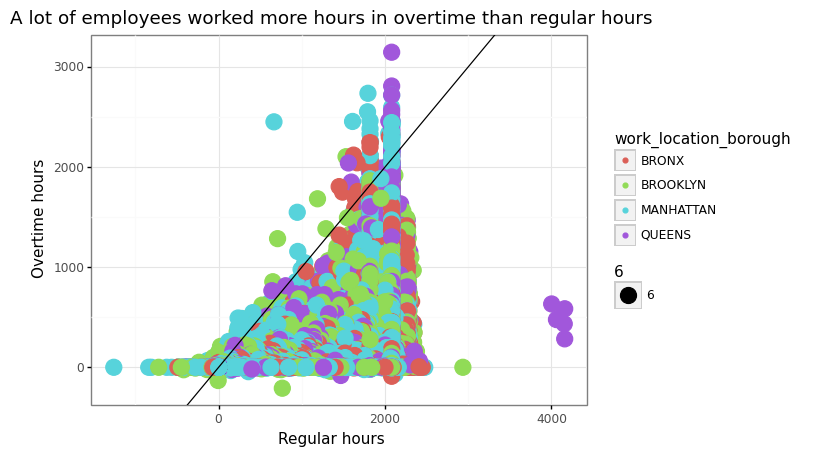

<ggplot: (357808119)>

In [28]:
(
    ggplot(df,
        aes('regular_hours', 'ot_hours'))
        + geom_point(aes(color='work_location_borough', size=6))
        + geom_abline(intercept = 0, slope = 1, color='black')
        + theme(figure_size=(8, 5))
        + theme_bw()
        + labs(
            title = "A lot of employees worked more hours in overtime than regular hours",
            y = "Overtime hours",
            x = "Regular hours"
        )
)

In [29]:
df.query('regular_hours > 3000')

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,total_pay
97605,2017,NaN,DEPARTMENT OF CORRECTION,JOHNSON,DAVID,NaN,05/26/2011,QUEENS,CORRECTION OFFICER,ACTIVE,"82,808.00",per Annum,"4,003.43","141,953.44",632.50,"39,454.30","21,003.88","202,411.62"
616041,2018,72.00,DEPARTMENT OF CORRECTION,JOHNSON,DAVID,NaN,05/26/2011,QUEENS,CORRECTION OFFICER,ACTIVE,"85,292.00",per Annum,"4,060.92","165,479.60",476.50,"34,085.39","24,040.34","223,605.33"
1162292,2019,72.00,DEPARTMENT OF CORRECTION,JOHNSON,DAVID,NaN,05/26/2011,QUEENS,CORRECTION OFFICER,ACTIVE,"85,292.00",per Annum,"4,154.40","178,494.76",434.00,"30,841.24","26,132.35","235,468.35"
1811475,2020,72.00,DEPARTMENT OF CORRECTION,JOHNSON,DAVID,NaN,05/26/2011,QUEENS,CORRECTION OFFICER,ACTIVE,"85,292.00",per Annum,"4,160.00","169,314.96",584.50,"20,853.77","30,833.61","221,002.34"
2292184,2021,72.00,DEPARTMENT OF CORRECTION,JOHNSON,DAVID,NaN,05/26/2011,QUEENS,CORRECTION OFFICER,ACTIVE,"92,073.00",per Annum,"4,160.00","181,564.57",284.00,"11,687.42","27,117.90","220,369.89"


In [30]:
df.query('ot_hours > 2000')

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,total_pay
6752,2017,NaN,ADMIN FOR CHILDREN'S SVCS,UDDIN,MOHAMED,F,10/27/2003,MANHATTAN,MOTOR VEHICLE OPERATOR,ACTIVE,"46,476.00",per Annum,"2,085.72","47,816.99","2,459.75","92,255.31","6,848.40","146,920.70"
6988,2017,NaN,ADMIN FOR CHILDREN'S SVCS,WATKINS,TYRONE,M,11/05/2001,MANHATTAN,CUSTODIAN,ACTIVE,"36,071.00",per Annum,"2,085.72","36,524.32","2,420.00","66,307.25","3,520.25","106,351.82"
88859,2017,NaN,DEPARTMENT OF BUILDINGS,CHERENFANT,DANIEL,F,12/07/2008,MANHATTAN,COMMUNITY ASSOCIATE,ACTIVE,"45,156.00",per Annum,"1,795.00","45,598.06","2,736.67","63,325.21",164.65,"109,087.92"
93910,2017,NaN,DEPARTMENT OF CORRECTION,CORCORAN,DERMOT,NaN,03/22/1993,QUEENS,SUPERVISOR OF MECHANICS,ACTIVE,476.40,per Day,"2,085.72","127,349.33","2,036.50","187,466.90","9,311.06","324,127.29"
97803,2017,NaN,DEPARTMENT OF CORRECTION,JONES,TANYA,NaN,07/05/1990,QUEENS,CAPTAIN,ACTIVE,"103,585.00",per Annum,"2,085.72","98,143.82","2,003.50","153,723.23","15,604.42","267,471.47"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376669,2021,816.00,DEPT OF HEALTH/MENTAL HYGIENE,MARTINEZ,LEONARDO,NaN,07/06/2009,MANHATTAN,INSTITUTIONAL AIDE,ACTIVE,"39,804.00",per Annum,"2,080.00","39,692.00","2,351.75","68,445.02","3,927.33","112,064.35"
2382831,2021,816.00,DEPT OF HEALTH/MENTAL HYGIENE,DIAZ,HIPOLITO,NaN,07/06/2009,MANHATTAN,INSTITUTIONAL AIDE,ACTIVE,"39,804.00",per Annum,"2,080.00","39,692.00","2,292.50","66,530.85","3,927.33","110,150.18"
2387130,2021,816.00,DEPT OF HEALTH/MENTAL HYGIENE,LINTA,FELICIA,NaN,10/16/2006,MANHATTAN,INSTITUTIONAL AIDE,ACTIVE,"39,804.00",per Annum,"2,080.00","39,692.00","2,230.75","64,866.69","3,817.71","108,376.40"
2401091,2021,816.00,DEPT OF HEALTH/MENTAL HYGIENE,PUJOLS-BAEZ,ROSA,D,07/06/2009,MANHATTAN,INSTITUTIONAL AIDE,ACTIVE,"39,804.00",per Annum,"2,080.00","39,692.00","2,106.00","61,010.09","3,251.79","103,953.88"


In [31]:
df['hrs_diff'] = df.ot_hours - df.regular_hours

In [32]:
df.query('regular_hours > 0').sort_values(by='hrs_diff', ascending = False).query('hrs_diff > 1').query('leave_status_as_of_june_30 == "CEASED"')

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,total_pay,hrs_diff
1705627,2020,56.00,POLICE DEPARTMENT,MURTHA,KEVIN,NaN,04/30/1995,MANHATTAN,LIEUTENANT D/A SPECIAL ASSIGNMENT,CEASED,"141,196.00",per Annum,665.18,"48,008.86","2,451.57","162,000.47","78,132.88","288,142.21","1,786.39"
1558323,2019,810.00,DEPARTMENT OF BUILDINGS,CHERENFANT,DANIEL,F,12/07/2008,MANHATTAN,COMMUNITY ASSOCIATE,CEASED,"47,095.00",per Annum,945.00,"30,016.98","1,548.25","38,217.55",372.26,"68,606.79",603.25
2319996,2021,57.00,FIRE DEPARTMENT,CAMPANELLI,JAMES,R,09/08/1991,BROOKLYN,PILOT,CEASED,"105,926.00",per Annum,708.60,"35,979.05","1,285.00","67,990.37","36,284.10","140,253.52",576.40
2293332,2021,57.00,FIRE DEPARTMENT,SENATORE,ROBERT,L,10/15/1995,BROOKLYN,PILOT,CEASED,"105,926.00",per Annum,"1,531.43","77,768.12","2,103.37","115,226.89","15,221.53","208,216.54",571.94
2305260,2021,57.00,FIRE DEPARTMENT,SIMMONS,JOHN,J,10/28/2001,BROOKLYN,FIRE MARSHAL,CEASED,"95,527.00",per Annum,"1,188.60","54,431.18","1,683.00","76,079.23","29,798.06","160,308.47",494.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247278,2020,996.00,NYC HOUSING AUTHORITY,WIELGOSINSKI,PAWEL,NaN,05/01/2017,MANHATTAN,ELECTRICIAN'S HELPER,CEASED,260.05,per Day,35.00,"1,301.55",36.50,"2,033.99",864.90,"4,200.44",1.50
1987492,2020,466.00,COMMUNITY COLLEGE (MANHATTAN),ULLOA,HARLO,NaN,03/18/2019,MANHATTAN,STUDENT AIDE,CEASED,15.00,per Hour,15.00,225.00,16.50,247.50,0.00,472.50,1.50
1783961,2020,57.00,FIRE DEPARTMENT,WALTERS,WAYNE,J,05/05/2002,BROOKLYN,FIREFIGHTER,CEASED,"85,292.00",per Annum,22.87,935.01,24.00,"1,097.02","15,370.00","17,402.03",1.13
525847,2017,NaN,POLICE DEPARTMENT,HUNTER-CLARK,TOBIA,M,07/18/1996,MANHATTAN,SERGEANTD/A SUPERVISOR DETECTIVE SQUAD,CEASED,"118,902.00",per Annum,102.87,"35,647.26",104.00,"11,448.78","4,849.41","51,945.45",1.13


In [33]:
# Final sanity check
df.fiscal_year.value_counts()

2019    571230
2020    568895
2021    552822
2017    541957
2018    525778
Name: fiscal_year, dtype: int64

# Check-In #2 with Dhrumil!

Goal: zoom out, identify a few possible questions that will hopefully lead to story angles.

I have provided some tools below that you can use to find these stories. Just look for this emoji "👈". That will show you places in the code you can make small changes to look at different subsets of the data.

This analysis starts with an assumption. The amount of regular hours of work someone does is proportional to the amount of overtime hours they do. That's our model `ot_hours ~ regular_hours` (I later changed it to a squared term `ot_hours ~ I(regular_hours**2)` because that fit slightly better, but either one works just fine). **additional note:** _I later thanged it from `ot_hours ~ I(regular_hours**2)` to `ot_hours ~ I(regular_hours**5)` because that fits even better 😲...message me on slack if you need me to explain this..._

In [382]:
import statsmodels.formula.api as smf

# YOU CAN ADD FILTERS HERE IF YOU WANT TO LOOK INTO A PARTICULAR AGENCY
# Let's start with no filters
to_model = df # .query("agency_name=='DEPARTMENT OF CORRECTION'")


# MODEL y=F(X) - which factors do you want to control for? 
# What do we think should explain the variance in overtime pay
model = smf.ols('ot_hours ~ I(regular_hours**5)', data=to_model) 
# note that I added a squared term because it fits better
# https://stackoverflow.com/questions/31978948/python-stats-models-quadratic-term-in-regression

results = model.fit()
display(results.summary())

# FINDING OUTLIERS
# + E (what is still unaccounted for once you have controlled for those factors)
outliers = to_model.assign(
    predicted = results.predict(),
    residulas = results.resid,
    residuals_z = results.resid / results.resid.std()
    )\
    .sort_values(by='residuals_z', ascending=False)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ot_hours   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 21 Apr 2022   Prob (F-statistic):                nan
Time:                        18:12:18   Log-Likelihood:            -1.7121e+07
No. Observations:             2760682   AIC:                         3.424e+07
Df Residuals:                 2760681   BIC:                         3.424e+07
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2.244e-31   1.33e-34   1690.273      0.000    2.24e-31    2.25e-31
I(regular_hours ** 5)  7.177e-15   4.25e-18   1690.273      0.000    7.17e-15    7.19e-15
==============================================================================
Omnibus:                  2029423.959   Durbin-Watson:                   1.335
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        416463082.005
Skew:                           2.587   Prob(JB):                         0.00
Kurtosis:                      62.948   Cond. No.                     2.00e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+16. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Who are the biggest outliers?

Here is a dataframe containing our friend KEVIN MURTHA. Who is Kevin Murtha was a great opening question for your analysis! But if we want to apply the same logic that we used to find Kevin Murtha, here are 25 other Kevin Murthas (note...25 is arbitrary, open the `overtime_outliers.csv` to see them all).


In [385]:
outliers.to_csv('overtime_outliers.csv', index=False) # preivew the df below, open the CSV for details
outliers.head(25)[['fiscal_year', 'agency_name', 'first_name', 'last_name', 
                   'title_description',  'residuals_z', 'ot_hours', 'regular_gross_paid', 'total_ot_paid']]

,fiscal_year,agency_name,first_name,last_name,title_description,ot_hours,residuals_z,regular_gross_paid,total_ot_paid
1811427,2020,DEPARTMENT OF CORRECTION,OMAR,MALCOLM,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,"3,147.00",24.01,"110,385.63","127,375.43"
88859,2017,DEPARTMENT OF BUILDINGS,DANIEL,CHERENFANT,COMMUNITY ASSOCIATE,"2,736.67",21.80,"45,598.06","63,325.21"
2291089,2021,DEPARTMENT OF CORRECTION,DEMETRIA,GIVES,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,"2,809.50",21.19,"127,452.46","162,012.85"
1705627,2020,POLICE DEPARTMENT,KEVIN,MURTHA,LIEUTENANT D/A SPECIAL ASSIGNMENT,"2,451.57",20.52,"48,008.86","162,000.47"
2368473,2021,DEPT OF CITYWIDE ADMIN SVCS,WILLIAM,GITTENS,CITY CUSTODIAL ASSISTANT,"2,719.75",20.44,"36,811.16","74,661.05"
2291260,2021,FIRE DEPARTMENT,MICHAEL,GAGER,MARINE ENGINEER,"2,716.92",20.41,"91,793.92","144,552.27"
968264,2018,DEPARTMENT OF BUILDINGS,DANIEL,CHERENFANT,COMMUNITY ASSOCIATE,"2,551.92",20.27,"44,290.79","62,912.63"
589227,2018,ADMIN FOR CHILDREN'S SVCS,HOWARD,KNOX,PAINTER,"2,455.50",19.91,"76,057.80","161,571.14"
2291081,2021,BOARD OF ELECTION,ANTONIO,"ORTIZ, JR",SENIOR SYSTEMS ANALYSTS,"2,461.25",19.41,"116,673.77","217,915.94"
2291396,2021,DEPT. OF HOMELESS SERVICES,CARL,YOUNG,CITY LABORER,"2,596.25",19.40,"75,400.00","152,639.79"


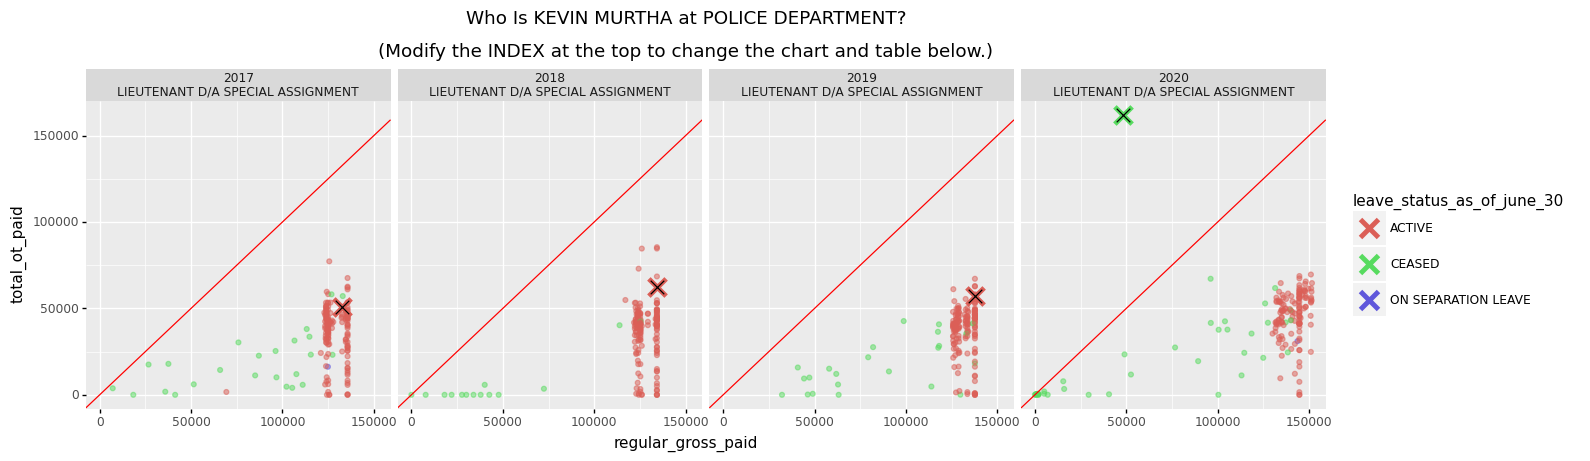

<ggplot: (733315250)>

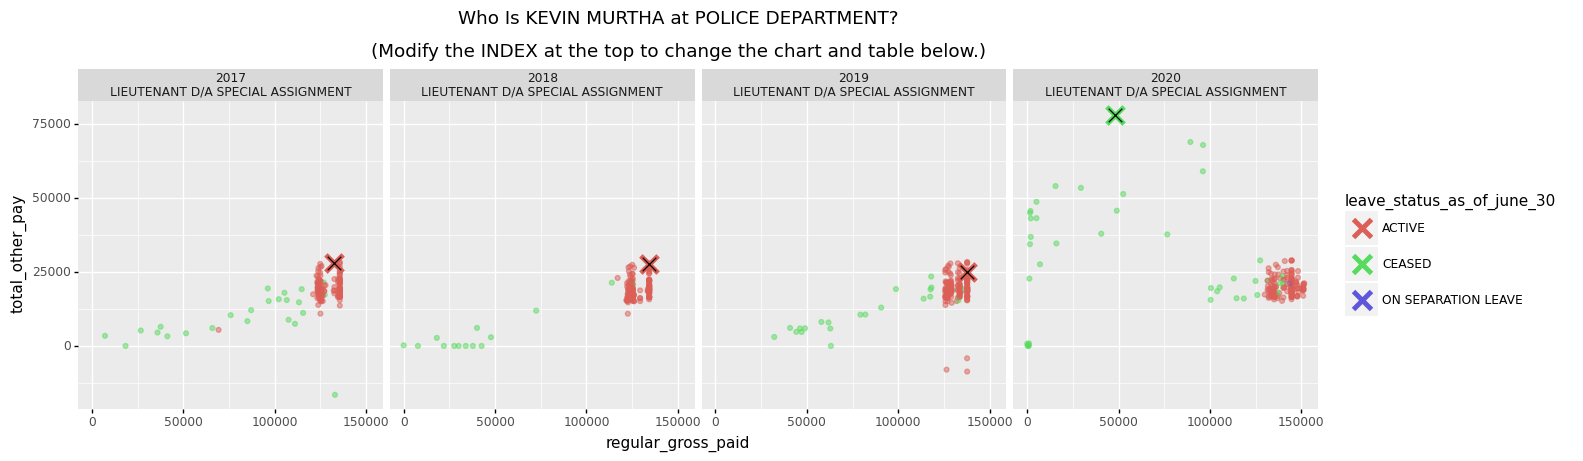

<ggplot: (1048320832)>

Here is a preview of the dataframe below with the person you selected. Check out overtime_outliers.csv if you're curious about other data points or change the INDEX to someone else and rerun the cell


,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,total_pay,hrs_diff,predicted,residulas,residuals_z,residuals_above_threshold
1705627,2020,56.00,POLICE DEPARTMENT,MURTHA,KEVIN,NaN,04/30/1995,MANHATTAN,LIEUTENANT D/A SPECIAL ASSIGNMENT,CEASED,"141,196.00",per Annum,665.18,"48,008.86","2,451.57","162,000.47","78,132.88","288,142.21","1,786.39",0.93,"2,450.64",20.52,residual_z>10
1082287,2018,56.00,POLICE DEPARTMENT,MURTHA,KEVIN,NaN,04/30/1995,BROOKLYN,LIEUTENANT D/A SPECIAL ASSIGNMENT,ACTIVE,"138,089.00",per Annum,"2,045.72","134,294.80",536.33,"62,473.98","27,815.30","224,584.08","-1,509.39",257.16,279.17,2.34,residual_z<=10
539518,2017,NaN,POLICE DEPARTMENT,MURTHA,KEVIN,NaN,04/30/1995,BROOKLYN,LIEUTENANT D/A SPECIAL ASSIGNMENT,ACTIVE,"134,067.00",per Annum,"2,051.43","132,640.94",433.70,"50,799.80","28,006.50","211,447.24","-1,617.73",260.77,172.93,1.45,residual_z<=10
1697037,2019,56.00,POLICE DEPARTMENT,MURTHA,KEVIN,NaN,04/30/1995,BROOKLYN,LIEUTENANT D/A SPECIAL ASSIGNMENT,ACTIVE,"138,089.00",per Annum,"2,040.00","137,710.56",387.87,"57,280.57","25,084.00","220,075.13","-1,652.13",253.58,134.29,1.12,residual_z<=10


In [435]:
# select a person using the index in the DF above 
INDEX = 1705627 
person = outliers.loc[INDEX] # a person in a given year

# try and grab that person's records in other years (you may need to modify these queries)
person_in_all_years = outliers\
    .query('last_name==@person.last_name and first_name==@person.first_name')\
    .query('agency_name==@person.agency_name')\
    .query('agency_start_date==@person.agency_start_date')

# this will fail if we've identified more than one person 
# (5 records max 2017-2021) or if we identified 0 people
try:
    assert(len(person_in_all_years) <= 5)
    assert(len(person_in_all_years) > 0)
except: 
    print(f"person_in_all_years returned {len(person_in_all_years)} records (should be between 1 and 5)")
    print(f"please modify that query so it refers to only one person")
    raise

# get other people in that agency/job/year for comparison
similar_people = []
for i, my in person_in_all_years.iterrows():
    similar_people_this_year = df\
        .query("fiscal_year == @my.fiscal_year")\
        .query("agency_name == @my.agency_name")\
        .query("title_description == @my.title_description")
    similar_people.append(similar_people_this_year)
    
other_people_in_the_same_position = pd.concat(similar_people)

# PLOT!
plt = (
    ggplot(other_people_in_the_same_position, 
           aes(x='regular_gross_paid', y='total_ot_paid')) +
        geom_point(aes(color='leave_status_as_of_june_30'), alpha=.5) + 
        geom_point(aes(color='leave_status_as_of_june_30'), data=person_in_all_years, shape='x',size=5, stroke=2) + 
        geom_point(data=person_in_all_years, shape='x',size=5) + 
        geom_abline(intercept=0, slope=1, color='red') +
        facet_wrap(['fiscal_year', 'title_description'], nrow=1) +
        ggtitle(f"Who Is {person.first_name} {person.last_name} at {person.agency_name}?\n\n(Modify the INDEX at the top to change the chart and table below.)") + 
        theme(figure_size=(16,4))
)

# PLOT!
plt2 = (
    ggplot(other_people_in_the_same_position, 
           aes(x='regular_gross_paid', y='total_other_pay')) +
        geom_point(aes(color='leave_status_as_of_june_30'), alpha=.5) + 
        geom_point(aes(color='leave_status_as_of_june_30'), data=person_in_all_years, shape='x',size=5, stroke=2) + 
        geom_point(data=person_in_all_years, shape='x',size=5) + 
        facet_wrap(['fiscal_year', 'title_description'], nrow=1) +
        ggtitle(f"Who Is {person.first_name} {person.last_name} at {person.agency_name}?\n\n(Modify the INDEX at the top to change the chart and table below.)") + 
        theme(figure_size=(16,4))
)

display(plt) # show plot
display(plt2) # show plot2
print('Here is a preview of the dataframe below with the person you selected. Check out overtime_outliers.csv if you\'re curious about other data points or change the INDEX to someone else and rerun the cell')
display(person_in_all_years) # show table

Awesome! Now you can modify the `INDEX` variable in the dataframe and re-run the above cells to see Kevin Murtha-like people in other agencies. This could be a handful of leads for possible stories. Time to start reporting!

"Who is Kevin Murtha" was a great question...but who is.. OMAR MALCOLM? ROBERT PROCIDA? HOWARD KNOX? 

Modify the `INDEX` variable in the dataframe and re-run the above to look into any particular person relative to others in similar roles. It's probably also a good time to leave the data notebook and start reporting!!!

## What departments do they work in? 

⚠️ **methodological choice alert**

note: when you make this choice, you are drawing attention away from individual people who are outliers and drawing attention towards particular professions/agencies that are prone to work overtimne. So by filtering and getting `value_counts` in this way, something is lost. 

Take, for example MICHAEL GAGER, a MARINE ENGINEER for the FIRE DEPARTMENT `(residuals_z == 20.41)`. He is not represented in the professions with the most people with high residuals below. Or the police officer you identified earlier KEVIN MURTHA `(residuals_Z==20.52)`. He is also not represented below. 

See the note in the cell below about the thresholds.

In [442]:
# These are the biggest outliers (z score greater than 10)
# however if you mess with that threshold, you'll get different agencies/titles
# so there may be some agencies with more outliers that are less...outlier-y
# that you don't capture until you change the threshold from say 10 to 3

THRESHOLD = 10 # 👉 try changing this to 3 and see what happens...
               # neither is "wrong", they just surface different things
               # higher threshold means you get the outlier-iest outliers
               # lower threshold means you get all the outliers
               # I wouldn't set it to less than 3 (at that point you're not really looking at outliers at all)
               #      z-score of less than 3 that would put you in the "fat" part of the bell curve...
outliers['residuals_above_threshold'] = outliers.residuals_z.apply(lambda x: f'residual_z>{THRESHOLD}' if x > THRESHOLD else f'residual_z<={THRESHOLD}')


agencies_containing_outliers = outliers\
    .pivot_table(index=['agency_name', 'title_description'], aggfunc='count', 
                 columns='residuals_above_threshold', values='first_name')\
    .fillna(0).astype(int).reset_index()\
    .assign(
        pct = lambda df: df[f'residual_z>{THRESHOLD}'] / (df[f'residual_z>{THRESHOLD}'] + df[f'residual_z<={THRESHOLD}']) * 100
    ).rename_axis(None, axis=1)

# display
COLUMN_TO_SORT_BY = f'residual_z>{THRESHOLD}'
agencies_containing_outliers\
    .sort_values(by=COLUMN_TO_SORT_BY, ascending=False)\
    .head(10)

,agency_name,title_description,residual_z<=10,residual_z>10,pct
1798,DEPARTMENT OF CORRECTION,CORRECTION OFFICER,51241,157,0.31
1766,DEPARTMENT OF CORRECTION,CAPTAIN,4412,76,1.69
5550,NYC HOUSING AUTHORITY,MAINTENANCE WORKER,5858,36,0.61
5564,NYC HOUSING AUTHORITY,PLUMBER,520,26,4.76
3403,DEPT OF HEALTH/MENTAL HYGIENE,INSTITUTIONAL AIDE,60,24,28.57
4899,HRA/DEPT OF SOCIAL SERVICES,ELIGIBILITY SPECIALIST,12262,22,0.18
87,ADMIN FOR CHILDREN'S SVCS,CONGREG CARE SPEC - ACS,532,21,3.80
2506,DEPARTMENT OF SANITATION,SUPERVISOR,5175,21,0.40
4922,HRA/DEPT OF SOCIAL SERVICES,JOB OPPORTUNITY SPECIALIST,7011,20,0.28
2826,DEPT OF CITYWIDE ADMIN SVCS,CUSTODIAN,963,19,1.93


Here is our story about PLUMBERs at NYC HOUSING AUTHORITY that you were able to identify. Looks like we're on the right track, since as you learned from your background reading, it seems like there was [some wrongdoing there](https://twitter.com/thecityny/status/1128017319437971456) around overtime pay. So these are some leads for other "Plumbers at NYCHA" style stories. Are there other professions/departments that show the same kind of patterns? Why Focus on PLUMBERs at NYC HOUSING AUTHORITY...instead of say MAINTENANCE WORKERs in the same department?

These residuals give us a clue about where else to look. For example, what's up at the DEPARTMENT OF CORRECTION? Lots of people there seem to be getting relatively more ot_hours compared to regular_hours. I wonder why?

In [443]:
agencies_containing_outliers = agencies_containing_outliers\
    .assign(
        pct = lambda df: df[f'residual_z>{THRESHOLD}'] / (df[f'residual_z>{THRESHOLD}'] + df[f'residual_z<={THRESHOLD}']) * 100
    ).rename_axis(None, axis=1)

**note:** Raw number of outlier people are interesting, and I think it is worth investigating the DEPARTMENT OF CORRECTION. I would follow that lede and try to remake the charts for DEPARTMENT OF CORRECTION employees of interest. But the DEPARTMENT OF CORRECTION is also huge!

Above, I create a variable that helps us normalize for the size of the department so that we don't overlook stories of groups of people that are getting lots of overtime pay in smaller departments. Let's see what we find.

In [444]:
agencies_containing_outliers\
    .sort_values(by='pct', ascending=False).head(10)

,agency_name,title_description,residual_z<=10,residual_z>10,pct
1834,DEPARTMENT OF CORRECTION,MARINE OILER,4,5,55.56
2914,DEPT OF CITYWIDE ADMIN SVCS,SUPERVISOR,3,2,40.00
2926,DEPT OF CITYWIDE ADMIN SVCS,SUPERVISOR PLUMBER,3,2,40.00
2795,DEPT OF CITYWIDE ADMIN SVCS,CEMENT MASON,3,2,40.00
273,BOARD OF ELECTION,SENIOR SYSTEMS ANALYSTS,10,5,33.33
3403,DEPT OF HEALTH/MENTAL HYGIENE,INSTITUTIONAL AIDE,60,24,28.57
130,ADMIN FOR CHILDREN'S SVCS,PAINTER,11,4,26.67
1760,DEPARTMENT OF CORRECTION,AUTO BODY WORKER,9,3,25.00
1833,DEPARTMENT OF CORRECTION,MARINE ENGINEER,22,7,24.14
255,BOARD OF ELECTION,COMPUTER SPECIALIST,16,5,23.81


Hmm...24 out of 60 INSTITUTIONAL AIDEs at DEPT OF HEALTH/MENTAL HYGIENE are outliers to our model...I wonder why? I might want to check the spreadsheet for INSTITUTIONAL AIDEs. What does an INSTITUTIONAL AIDE do? How much do they earn? Maybe this is normal...maybe it's a story? What about some of these other folks that are logging overtime at other departments? 

You can use this information to go and find individual people of interest in the CSV file. Plug them into the chart at the top of this section and see what the norm is in their profession and department.

## Looking at data by department

Dhrumil is tired...here are a bunch of charts you can work with if you'd like. OR just stick to the chart above. It is pretty informative to look at a particular person in the context of their profession + department. Just note that everything I did above makes that methodological choice. Why are we not looking, for example, at electricians across all departments. I don't know...I just didn't get around to it.

What I have done, is use the regression to generalize the logic you used to get to the Kevin Murtha story and the plumbers in NYCHA story. 

In [ ]:
# Here is that list of outliers one more time

# it is sorted by the z-score of the residuals from the model
# so people who got more overtime relative to regular pay will be surfaced
to_view =  outliers.\
    sort_values(by='residuals_z', ascending=False)\
    [['agency_name','title_description','residuals_z', 'last_name','first_name', 'mid_init', 
         'agency_start_date', 'total_ot_paid', 'regular_gross_paid', 'total_other_pay']]

to_view.to_csv('to_view.csv') # look at this CSV file to check particular departments

# OR try some queries...
# to_view = to_view.query('agency_name=="DEPT OF CITYWIDE ADMIN SVCS"')
# to_view = to_view.query('title_description=="ELECTRICIAN"')
# to_view = to_view.query('total_ot_paid > 100000')

to_view.sort_values(by='total_ot_paid', ascending=False)

# bunch of other charts...you can use these, or ignore them. 

R[write to console]: Rows: 2760682 Columns: 22

R[write to console]: ── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): agency_name, last_name, first_name, mid_init, agency_start_date, w...
dbl (13): fiscal_year, payroll_number, base_salary, regular_hours, regular_g...

R[write to console]: 
ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



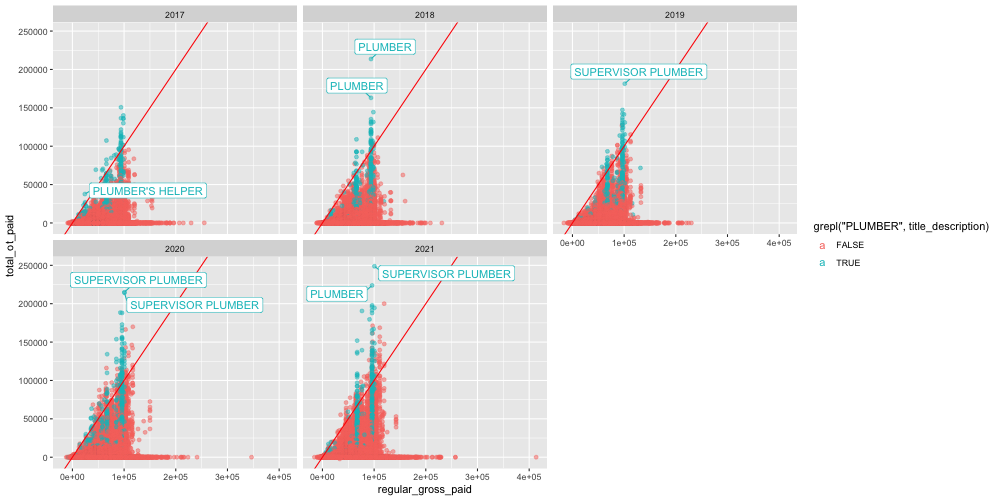

In [335]:
# %%R -w 1000 -h 500

# require('readr')
# require('tidyverse')
# require('ggrepel')

# # WANT TO LOOK AT A PARTICULAR SUBSET OF PEOPLE? 
# # FILTER THEM HERE!
# df <- read_csv('overtime_outliers.csv') %>%
#     filter(agency_name == 'NYC HOUSING AUTHORITY')

# # WANT TO HIGHLIGHT PARTICULAR DATA POINTS?  
# to_highlight <- df %>%
#     filter(grepl('PLUMBER', title_description)) # regex search

# # WANT TO LABEL PARTICULAR PEOPLE? 
# to_label <- df %>%
#     filter(total_ot_paid > regular_gross_paid)

# # plot
# ggplot(df, aes(x=regular_gross_paid, y=total_ot_paid)) +
#     aes(color=grepl('PLUMBER', title_description)) +
#     geom_point(alpha=.5) +
#     geom_abline(intercept=0, slope=1, color='red') + 
#     geom_label_repel(data = to_label, 
#                      aes(label=title_description), 
#                      min.segment.length = 0) + # geom_label_repel labels at least one of every type of label in data
#     facet_wrap(~fiscal_year)
    

In [354]:
# # Same as above, but in python/plotnine (very slow)

# # WANT TO LOOK AT A PARTICULAR SUBSET OF PEOPLE? 
# to_plot = outliers.query("agency_name == 'NYC HOUSING AUTHORITY'")

# # WANT TO HIGHLIGHT PARTICULAR DATA POINTS?  
# highlight_query = "title_description.str.contains('PLUMBER')"
# to_highlight = to_plot.query(highlight_query)

# # WANT TO LABEL PARTICULAR PEOPLE? 
# to_label = to_highlight.query("residuals_z > 10")

# # https://stackoverflow.com/questions/57701052/how-do-i-use-adjust-text-with-plotnine
# adjust_text_settings = {'expand_points': (2, 2), 'arrowprops': {'arrowstyle': '->', 'color': 'red'}}

# display(
#     ggplot(df, 
#            aes(x='regular_gross_paid', y='total_ot_paid')) +
#         geom_point(alpha=.2) +
#         geom_point(data=to_highlight, color='red', alpha=1) +
#         geom_abline(intercept=0, slope=1, color='red') + 
#         geom_text(to_label, aes(label='first_name'), adjust_text=adjust_text_settings) +
#         facet_wrap('fiscal_year') + 
#         theme(figure_size = (16,9))
# )

# display(to_label)


KeyboardInterrupt



## And what is going on at that agency overall?

Let's look at the bigger picture of that agency. Are they leaning more heavily on overtime workers? 

This is the kind of analysis that lets you do more big trend stories. I have a feeling that the previous two sections will guide you to more compelling stories, but this could be additional context if it is helpful.

In [445]:


# # reads the same variables from above (to_plot)
# # but plots a histogram instead of a dot plot

# to_plot.query(f"residuals_above_threshold == 'residual_z>{THRESHOLD}'")\
#     .title_description\
#     .value_counts()
# # ggplot(to_plot, aes(x=ot_hours)) +
# #     geom_histogram() +
# #     facet_grid(title_description=='CORRECTION OFFICER'~fiscal_year)
    

MAINTENANCE WORKER                   34
PLUMBER                              21
HEATING PLANT TECHNICIAN             14
PLUMBER'S HELPER                     10
ELECTRICIAN                           8
CARPENTER                             7
CARETAKER                             7
SUPERVISOR PLUMBER                    6
ELEVATOR MECHANIC                     4
RESIDENT BUILDING SUPERINTENDENT      4
SUPERVISOR PAINTER                    4
SUPERVISOR BRICKLAYER                 3
SUPERVISOR ELECTRICIAN                3
SUPERVISING HOUSING GROUNDSKEEPER     2
ELECTRICIANS HELPER                   2
SUPERVISOR OF HOUSING CARETAKER       2
SUPERVISOR CARPENTER                  2
*HOUSING CARETAKER                    1
MASONS HELPER                         1
OIL BURNER SPECIALIST                 1
PAINTER                               1
SUPERVISOR ROOFER                     1
ASSISTANT RESIDENT BUILDING SUPT      1
SUPERVISOR PLASTERER                  1
ELEVATOR MECHANIC HELPER              1


In [39]:
median_ot = df.pivot_table(index='agency_name', values='ot_hours', aggfunc=['mean'], columns='fiscal_year').reset_index()
median_ot['diff'] = median_ot[(     'mean', 2021)] - median_ot[(     'mean', 2017)]
median_ot[median_ot[(       'diff',   '')] > 0]
# median_ot#.query("agency_name=='DEPT OF HEALTH/MENTAL HYGIENE'")
# len(median_ot.sort_values(by='diff').query('diff>0'))
# (
# ggplot(median_ot.melt(id_vars='agency_name'))
#     + aes(x='fiscal_year', y='value', group='agency_name') 
#     + geom_line(aes(color='agency_name')) 
    
# )   

agency_name   mean                       \
fiscal_year                                   2017   2018   2019   2020   
1                 ADMIN TRIALS AND HEARINGS   1.97   2.87   1.94   2.01   
2                       BOARD OF CORRECTION   0.00   0.23   0.00   0.00   
3                         BOARD OF ELECTION 320.55 235.18 326.46 263.86   
39            BUSINESS INTEGRITY COMMISSION  20.20  25.49  27.31  41.49   
40                   CAMPAIGN FINANCE BOARD  31.32  55.15  35.05  42.13   
51              CONFLICTS OF INTEREST BOARD   0.00   0.00   0.00   0.00   
55                 DEPARTMENT FOR THE AGING   0.30   0.43   0.66   0.87   
57             DEPARTMENT OF BUSINESS SERV.   5.21   4.08   3.62   8.44   
58              DEPARTMENT OF CITY PLANNING   2.67   1.49   1.39   1.15   
61                    DEPARTMENT OF FINANCE  28.92  31.23  39.49  50.14   
64                  DEPARTMENT OF PROBATION  26.56  30.25  52.45  45.57   
65                 DEPARTMENT OF SANITATION 194.15 224.50 193.98 214.22   
74            DEPT OF HEALTH/MENTAL HYGIENE  33.70  29.46  33.78  51.57   
76               DEPT OF PARKS & RECREATION  34.39  36.89  36.61  42.10   
78            DEPT OF YOUTH & COMM DEV SRVS   4.55   3.04   1.91   1.41   
80               DEPT. OF HOMELESS SERVICES 111.26 157.48 167.79 170.16   
87               FINANCIAL INFO SVCS AGENCY  12.98  12.71  15.74  18.29   
88                          FIRE DEPARTMENT 292.18 286.38 298.99 392.59   
90           HOUSING PRESERVATION & DVLPMNT  20.32  24.11  30.76  25.75   
91              HRA/DEPT OF SOCIAL SERVICES  65.94  64.54  69.86  75.16   
93               HUNTER COLLEGE HIGH SCHOOL   1.08   1.85   2.85   1.37   
114                   NYC HOUSING AUTHORITY 145.48 154.05 153.65 188.66   
116           OFF OF PAYROLL ADMINISTRATION   4.34   2.54   5.11   5.56   
118          OFFICE OF EMERGENCY MANAGEMENT  51.65  76.50  56.82 147.27   
119               OFFICE OF LABOR RELATIONS   0.00   0.00   0.03   0.00   

                     diff  
fiscal_year   2021         
1             6.23   4.26  
2             0.06   0.06  
3           467.86 147.31  
39           37.40  17.20  
40           71.65  40.33  
51            0.47   0.47  
55            1.51   1.21  
57            6.35   1.14  
58            3.29   0.62  
61           61.29  32.38  
64           27.82   1.26  
65          341.87 147.71  
74          112.33  78.63  
76           51.12  16.73  
78            9.46   4.90  
80          195.48  84.22  
87           17.69   4.71  
88          424.69 132.51  
90           22.28   1.96  
91           96.27  30.33  
93            1.15   0.07  
114         186.52  41.04  
116          16.31  11.97  
118         110.06  58.41  
119           0.43   0.43

In [40]:
pd.read_csv('highlighted.csv').query('title_description.str.contains("WARDEN")')

,Unnamed: 0,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,total_pay,hrs_diff,predicted,residulas,residuals_z
0,1,2020,72.00,DEPARTMENT OF CORRECTION,MALCOLM,OMAR,T,09/06/2012,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"111,142.00",per Annum,"2,080.00","110,385.63","3,147.00","127,375.43","13,559.40","251,320.46","1,067.00",207.51,"2,939.49",22.63
1,2,2021,72.00,DEPARTMENT OF CORRECTION,GIVES,DEMETRIA,NaN,10/23/1997,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"128,355.00",per Annum,"2,080.00","127,452.46","2,809.50","162,012.85","24,946.87","314,412.18",729.50,207.51,"2,601.99",20.03
11,12,2021,72.00,DEPARTMENT OF CORRECTION,MASSEY-COVINGTO,DARLENE,E,03/04/2004,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"128,355.00",per Annum,"2,080.00","127,452.46","2,161.00","111,907.50","19,537.03","258,896.99",81.00,207.51,"1,953.49",15.04
12,13,2020,72.00,DEPARTMENT OF CORRECTION,FOO,AINSWORTH,K,08/12/2004,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"111,142.00",per Annum,"2,080.00","110,385.63","2,118.50","96,209.69","18,323.60","224,918.92",38.50,207.51,"1,910.99",14.71
23,24,2020,72.00,DEPARTMENT OF CORRECTION,SKEPPLE,ASCHELLE,C,06/02/2005,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"125,531.00",per Annum,"2,080.00","120,684.33","2,034.25","100,902.58","17,111.90","238,698.81",-45.75,207.51,"1,826.74",14.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67664,67665,2019,72.00,DEPARTMENT OF CORRECTION,SHANNON,AISHA,I,06/06/2002,BRONX,WARDEN-DEPUTY WARDEN TED < 11/1/92,ACTIVE,"130,283.00",per Annum,"2,085.72","126,207.06",0.00,0.00,"25,684.89","151,891.95","-2,085.72",208.10,-208.10,-1.60
67675,67676,2019,72.00,DEPARTMENT OF CORRECTION,BARNABY,LISA,R,06/29/2006,MANHATTAN,WARDEN-DEPUTY WARDEN TED < 11/1/92,ACTIVE,"130,283.00",per Annum,"2,085.72","126,359.74",0.00,0.00,"12,674.06","139,033.80","-2,085.72",208.10,-208.10,-1.60
67676,67677,2019,72.00,DEPARTMENT OF CORRECTION,JOHNSON,KARL,D,01/18/1990,QUEENS,WARDEN-DEPUTY WARDEN TED < 11/1/92,ACTIVE,"130,283.00",per Annum,"2,085.72","125,905.10",0.00,0.00,"14,680.43","140,585.53","-2,085.72",208.10,-208.10,-1.60
67677,67678,2019,72.00,DEPARTMENT OF CORRECTION,GRIMA,JOSEPH,J,01/17/2008,QUEENS,WARDEN-DEPUTY WARDEN TED < 11/1/92,ACTIVE,"130,283.00",per Annum,"2,085.72","126,359.74",0.00,0.00,"15,198.19","141,557.93","-2,085.72",208.10,-208.10,-1.60
